In [1]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt


sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader
from src.models.lit_node import NODE, ToyODE

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test on a sphere

In [2]:
def sphere_metric(theta, phi):
    return torch.tensor([[1, 0], [0, torch.sin(theta) ** 2]])


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor

In [59]:
fn_ode = ToyODE(2, [20, 10, 10])
neural_ode = NODE(fn_ode, method="rk4")

In [71]:
init = 0.0
end = pi/2
delta = end - init
x0 = torch.tensor([init, 0]).view(1, 2)
x1 = torch.tensor([end, 0]).view(1, 2)

In [61]:
n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

In [62]:
neural_ode.train()
pre_epochs = 500
# for epoch in range(pre_epochs):

#     optimizer.zero_grad()

#     path = neural_ode(x0, n_steps).squeeze(1)

#     x1_pred = path[-1]

#     pred_loss = torch.nn.MSELoss()(x1_pred, x1)
#     loss = pred_loss
 
#     if epoch % 100 == 0:
#         print("Pre trained MSE: ",loss)

#     loss.backward()
#     optimizer.step()

for epoch in range(n_epochs):
    fn_ode.reset_path()
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=end).squeeze(1)
    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    cost = []
    n = len(neural_ode.path)
    for p0 in neural_ode.path:

        c = torch.sqrt(p0 @ sphere_metric(p0[0,0], p0[0,1]) @ p0.T).squeeze(0) #torch.sin(p[1,0])
        cost.append(c)

    loss = delta*sum(cost)/len(cost) + 100 * pred_loss

 
    if epoch % 100 == 0:
        print("Loss: ", loss)
        print("length: ", delta * sum(cost)/len(cost))

    loss.backward()
    optimizer.step()

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss:  tensor([232.3900], grad_fn=<AddBackward0>)
length:  tensor([0.5808], grad_fn=<DivBackward0>)
Loss:  tensor([49.5336], grad_fn=<AddBackward0>)
length:  tensor([0.5932], grad_fn=<DivBackward0>)
Loss:  tensor([1.5773], grad_fn=<AddBackward0>)
length:  tensor([1.5707], grad_fn=<DivBackward0>)
Loss:  tensor([1.5768], grad_fn=<AddBackward0>)
length:  tensor([1.5713], grad_fn=<DivBackward0>)
Loss:  tensor([1.5763], grad_fn=<AddBackward0>)
length:  tensor([1.5708], grad_fn=<DivBackward0>)
Loss:  tensor([1.5757], grad_fn=<AddBackward0>)
length:  tensor([1.5704], grad_fn=<DivBackward0>)
Loss:  tensor([1.5751], grad_fn=<AddBackward0>)
length:  tensor([1.5698], grad_fn=<DivBackward0>)
Loss:  tensor([1.5744], grad_fn=<AddBackward0>)
length:  tensor([1.5691], grad_fn=<DivBackward0>)
Loss:  tensor([1.5735], grad_fn=<AddBackward0>)
length:  tensor([1.5682], grad_fn=<DivBackward0>)
Loss:  tensor([1.5726], grad_fn=<AddBackward0>)
length:  tensor([1.5673], grad_fn=<DivBackward0>)


In [63]:
path = neural_ode(x0, n_steps, end_time=end).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

In [72]:
x0_e = polar_to_euc(x0)
x1_e = polar_to_euc(x1)

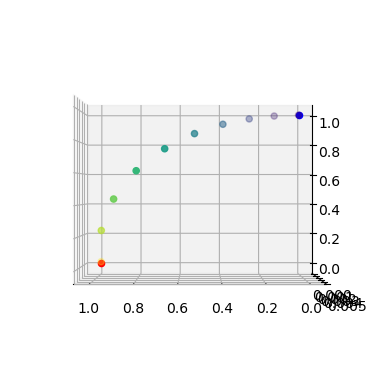

In [76]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.scatter(x0_e[0,0],x0_e[0,1],x0_e[0,2],c='blue')
ax.scatter(x1_e[0,0],x1_e[0,1],x1_e[0,2],c='red')
ax.view_init(0, 90)
plt.show()

In [43]:
# Without the metric loss.
fn_ode = ToyODE(2, [5, 5])
neural_ode = NODE(fn_ode, method="rk4")

n_epochs = 1000
n_steps = 10
optimizer = torch.optim.AdamW(params=neural_ode.parameters(), lr=0.001)

neural_ode.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    path = neural_ode(x0, n_steps, end_time=end).squeeze(1)

    x1_pred = path[-1]

    pred_loss = torch.nn.MSELoss()(x1_pred, x1)
    loss = pred_loss

    if epoch % 200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(7.2139, grad_fn=<MseLossBackward0>)
tensor(1.1003, grad_fn=<MseLossBackward0>)
tensor(4.1482e-07, grad_fn=<MseLossBackward0>)
tensor(1.9088e-07, grad_fn=<MseLossBackward0>)
tensor(1.2345e-07, grad_fn=<MseLossBackward0>)


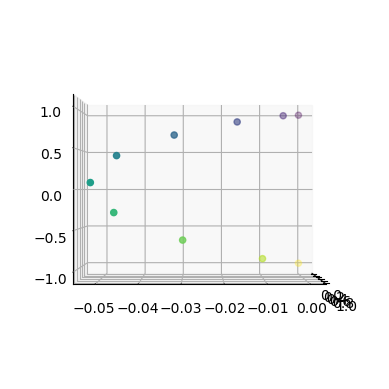

In [47]:
path = neural_ode(x0, n_steps, end_time=end).squeeze(1)
path_euc = polar_to_euc(path.detach().numpy())

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(n_steps)))
ax.view_init(0, 0)
plt.show()